In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import datetime
import os
from torch.utils.tensorboard import SummaryWriter
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shim

In [2]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title(f"Step: {step} {info}")
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

In [36]:
# Hyperparameters
hidden_dim = [128]
learning_rate = 0.001
gamma = 0.99
memory_size = 10000
batch_size = 128
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
num_episodes = 5000
tau = 0.0075
device = "cuda"

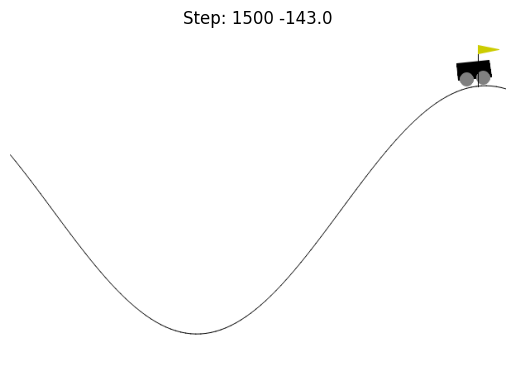

Episode: 1500, Total Reward: -144.0
Episode: 1501, Total Reward: -142.0
Episode: 1502, Total Reward: -163.0
Episode: 1503, Total Reward: -152.0
Episode: 1504, Total Reward: -145.0
Episode: 1505, Total Reward: -162.0
Episode: 1506, Total Reward: -157.0
Episode: 1507, Total Reward: -109.0
Episode: 1508, Total Reward: -144.0
Episode: 1509, Total Reward: -157.0
Episode: 1510, Total Reward: -144.0
Episode: 1511, Total Reward: -144.0
Episode: 1512, Total Reward: -146.0
Episode: 1513, Total Reward: -120.0
Episode: 1514, Total Reward: -107.0
Episode: 1515, Total Reward: -91.0
Episode: 1516, Total Reward: -147.0
Episode: 1517, Total Reward: -151.0
Episode: 1518, Total Reward: -95.0
Episode: 1519, Total Reward: -88.0
Episode: 1520, Total Reward: -89.0
Episode: 1521, Total Reward: -144.0
Episode: 1522, Total Reward: -118.0
Episode: 1523, Total Reward: -143.0
Episode: 1524, Total Reward: -90.0
Episode: 1525, Total Reward: -95.0
Episode: 1526, Total Reward: -101.0
Episode: 1527, Total Reward: -92.0

KeyboardInterrupt: 

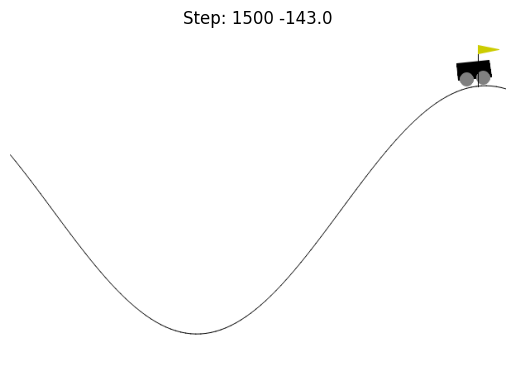

In [4]:
# Define the Q-Network
class DQN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DQN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            for i in range(len(hidden_sizes) - 1)
        ])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)  # 1 output for energy score
    
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        output = self.output_layer(x)
        return output

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)
    
def choose_action(state, current_action, epsilon, action_space_size=3):
    if random.random() < epsilon:
        # Brownian-like exploration: Slightly modify the current action
        action_step = np.random.randint(-1, 2)  # -1, 0, or 1
        new_action = (current_action + action_step) % action_space_size
        return new_action
    else:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        return q_values.max(1)[1].item()


# Function to update the target network
def update_target_model(tau=0.001):
    for target_param, model_param in zip(target_model.parameters(), model.parameters()):
        target_param.data.copy_(tau * model_param.data + (1.0 - tau) * target_param.data)

def optimize_model(batch_size):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
    
    batch_state = torch.from_numpy(np.array(batch_state)).to(device=device, dtype=torch.float32)
    batch_action = torch.from_numpy(np.array(batch_action)).to(device=device, dtype=torch.int64)
    batch_reward = torch.from_numpy(np.array(batch_reward)).to(device=device, dtype=torch.float32)
    batch_next_state = torch.from_numpy(np.array(batch_next_state)).to(device=device, dtype=torch.float32)
    batch_done = torch.from_numpy(np.array(batch_done)).to(device=device, dtype=torch.bool)

    current_q_values = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        next_action = model(batch_next_state).max(1)[1]
        max_next_q_values = target_model(batch_next_state).gather(1, next_action.unsqueeze(1)).squeeze(1)
    expected_q_values = batch_reward + (gamma * max_next_q_values * ~batch_done)

    loss = criterion(current_q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = os.path.join('log', 'MountainCar-v0', "dqn", now)
log_path = os.path.join(log_name)
writer = SummaryWriter(log_path)

# Environment setup
env = gym.make('MountainCar-v0', render_mode='rgb_array')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

# Model, optimizer, memory, and loss function
model = DQN(input_dim, hidden_dim, output_dim).to(device)
target_model = DQN(input_dim, hidden_dim, output_dim).to(device)
target_model.load_state_dict(model.state_dict()) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
memory = ReplayBuffer(memory_size)
criterion = nn.MSELoss()

# Training loop
epsilon = epsilon_start
global_step = 0

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    current_action = env.action_space.sample()

    while True:
        if episode % 500 == 0:
            show_state(env, step=episode, info=total_reward)
        action = choose_action(state, current_action, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = truncated or terminated
        memory.push(state, action, reward, next_state, terminated)
        loss = optimize_model(batch_size)
        if loss:
            writer.add_scalar("Train/Loss", loss, global_step)

        update_target_model(tau)
        current_action = action
        state = next_state
        total_reward += reward
        global_step += 1

        if done:
            writer.add_scalar("Train/Reward", total_reward, global_step)
            break        

    epsilon = max(epsilon_end, epsilon_decay * epsilon)
    print(f'Episode: {episode}, Total Reward: {total_reward}')

env.close()

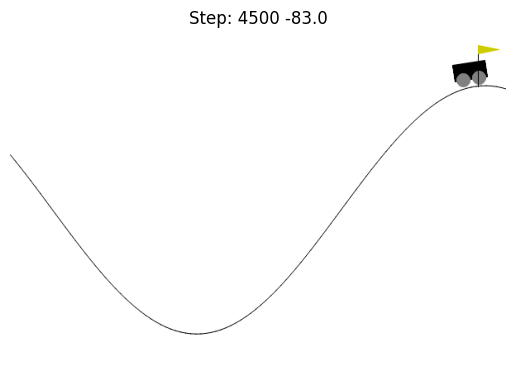

Episode: 4500, Total Reward: -84.0
Episode: 4501, Total Reward: -107.0
Episode: 4502, Total Reward: -98.0
Episode: 4503, Total Reward: -157.0
Episode: 4504, Total Reward: -93.0
Episode: 4505, Total Reward: -158.0
Episode: 4506, Total Reward: -85.0
Episode: 4507, Total Reward: -164.0
Episode: 4508, Total Reward: -122.0
Episode: 4509, Total Reward: -110.0
Episode: 4510, Total Reward: -84.0
Episode: 4511, Total Reward: -161.0
Episode: 4512, Total Reward: -88.0
Episode: 4513, Total Reward: -85.0
Episode: 4514, Total Reward: -183.0
Episode: 4515, Total Reward: -95.0
Episode: 4516, Total Reward: -85.0
Episode: 4517, Total Reward: -84.0
Episode: 4518, Total Reward: -161.0
Episode: 4519, Total Reward: -92.0
Episode: 4520, Total Reward: -157.0
Episode: 4521, Total Reward: -157.0
Episode: 4522, Total Reward: -159.0
Episode: 4523, Total Reward: -90.0
Episode: 4524, Total Reward: -162.0
Episode: 4525, Total Reward: -169.0
Episode: 4526, Total Reward: -157.0
Episode: 4527, Total Reward: -91.0
Episo

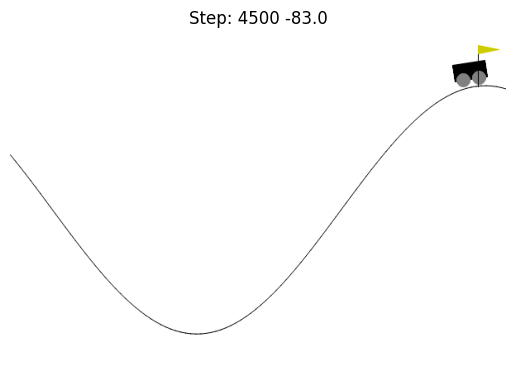

In [39]:
# Define the Q-Network
class DQN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DQN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            for i in range(len(hidden_sizes) - 1)
        ])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)  # 1 output for energy score
    
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        output = self.output_layer(x)
        return output

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.gamma = gamma  # Discount factor

    def push(self, state, action, reward, next_state, done, cum_discounted_reward):
        self.buffer.append((state, action, reward, next_state, done, cum_discounted_reward))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

def compute_cumulative_rewards(rewards, gamma):
    """
    Compute the cumulative discounted reward to go at each state.
    """
    cum_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        cum_rewards[t] = running_add
    return cum_rewards
    
def choose_action(state, current_action, epsilon, action_space_size=3):
    if random.random() < epsilon:
        # Brownian-like exploration: Slightly modify the current action
        action_step = np.random.randint(-1, 2)  # -1, 0, or 1
        new_action = (current_action + action_step) % action_space_size
        return new_action
    else:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        return q_values.max(1)[1].item()


# Function to update the target network
def update_target_model(tau=0.001):
    for target_param, model_param in zip(target_model.parameters(), model.parameters()):
        target_param.data.copy_(tau * model_param.data + (1.0 - tau) * target_param.data)

def optimize_model(batch_size):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch_state, batch_action, batch_reward, batch_next_state, batch_done, batch_cum_discounted_reward = zip(*transitions)
    
    batch_state = torch.from_numpy(np.array(batch_state)).to(device=device, dtype=torch.float32)
    batch_action = torch.from_numpy(np.array(batch_action)).to(device=device, dtype=torch.int64)
    batch_reward = torch.from_numpy(np.array(batch_reward)).to(device=device, dtype=torch.float32)
    batch_next_state = torch.from_numpy(np.array(batch_next_state)).to(device=device, dtype=torch.float32)
    batch_done = torch.from_numpy(np.array(batch_done)).to(device=device, dtype=torch.bool)
    batch_cum_discounted_reward = torch.from_numpy(np.array(batch_cum_discounted_reward)).to(device=device, dtype=torch.float32)

    current_q_values = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        next_action = model(batch_next_state).max(1)[1]
        max_next_q_values = target_model(batch_next_state).gather(1, next_action.unsqueeze(1)).squeeze(1)
    expected_q_values = batch_reward + (gamma * max_next_q_values * ~batch_done)
    penalty = torch.relu(current_q_values - batch_cum_discounted_reward - 5)
    loss = criterion(current_q_values, expected_q_values) + 0.1*penalty.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = os.path.join('log', 'MountainCar-v0', "dqn", now)
log_path = os.path.join(log_name)
writer = SummaryWriter(log_path)

# Environment setup
env = gym.make('MountainCar-v0', render_mode='rgb_array')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

# Model, optimizer, memory, and loss function
model = DQN(input_dim, hidden_dim, output_dim).to(device)
target_model = DQN(input_dim, hidden_dim, output_dim).to(device)
target_model.load_state_dict(model.state_dict()) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
memory = ReplayBuffer(memory_size)
criterion = nn.MSELoss()

# Training loop
epsilon = epsilon_start
global_step = 0

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    current_action = env.action_space.sample()
    episode_memory = []

    while True:
        if episode % 500 == 0:
            show_state(env, step=episode, info=total_reward)
        action = choose_action(state, current_action, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = truncated or terminated
        loss = optimize_model(batch_size)
        if loss:
            writer.add_scalar("Train/Loss", loss, global_step)

        update_target_model(tau)
        current_action = action
        episode_memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        global_step += 1

        if done:
            # Compute cumulative discounted rewards for the episode
            states, actions, rewards, next_states, dones = zip(*episode_memory)
            cum_rewards = compute_cumulative_rewards(rewards, memory.gamma)
            for i in range(len(episode_memory)):
                memory.push(states[i], actions[i], rewards[i], next_states[i], dones[i], cum_rewards[i])
                
            writer.add_scalar("Train/Reward", total_reward, global_step)
            break        

    epsilon = max(epsilon_end, epsilon_decay * epsilon)
    print(f'Episode: {episode}, Total Reward: {total_reward}')

env.close()

In [5]:
torch.save(model.state_dict(), "dqn_mcar.pth")

In [40]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
N = 100
avg_disc_rew = 0
avg_qs = 0
for _ in range(N):
    state, _ = env.reset(seed=0)
    rewards = []
    qs = []
    states = [state]

    while True:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        q_values = model(state_tensor)
        action = q_values.max(1)[1].item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = truncated or terminated
        state = next_state
        states.append(state)
        rewards.append(reward)
        qs.append(q_values.max(1)[0].item())
        if done:
            l = len(rewards)
            discounted_rewards_togo = [sum([(gamma**i)*rewards[i] for i in range(l-j, l)]) for j in range(l)]
            discounted_rewards_togo.reverse()
            avg_disc_rew += np.array(discounted_rewards_togo)
            avg_qs += np.array(qs)
            break

avg_disc_rew /= N
avg_qs /= N

In [41]:
list(zip(avg_qs, avg_disc_rew))

[(-69.66097259521484, -77.72742967709816),
 (-68.91403198242188, -76.73742967709791),
 (-68.17589569091797, -75.75732967709793),
 (-67.5142822265625, -74.78703067709812),
 (-66.93418884277344, -73.82643466709784),
 (-66.43991088867188, -72.87544461719796),
 (-66.0411148071289, -71.93396446779687),
 (-65.79583740234375, -71.00189911989013),
 (-65.66069030761719, -70.07915442546228),
 (-65.51419830322266, -69.16563717797838),
 (-65.44868469238281, -68.26125510296968),
 (-65.50494384765625, -67.36591684871104),
 (-65.68240356445312, -66.47953197699469),
 (-65.33391571044922, -65.60201095399587),
 (-64.94152069091797, -64.73326514122702),
 (-64.63961029052734, -63.873206786585726),
 (-64.42943572998047, -63.0217490154909),
 (-64.31131744384766, -62.17880582210668),
 (-64.28465270996094, -61.344292060656706),
 (-63.895599365234375, -60.518123436821064),
 (-63.45109939575195, -59.70021649922388),
 (-63.076271057128906, -58.890488631002796),
 (-62.771854400634766, -58.08885804146368),
 (-62.4

In [26]:
list(zip(avg_qs, avg_disc_rew))

[(-66.21207427978516, -72.46337502522947),
 (-65.89306640625, -71.47337502522922),
 (-65.60530090332031, -70.49327502522925),
 (-65.34556579589844, -69.52297602522953),
 (-64.99164581298828, -68.56238001522952),
 (-64.65460968017578, -67.61138996532925),
 (-64.33699035644531, -66.66990981592853),
 (-64.04119873046875, -65.73784446802144),
 (-63.429771423339844, -64.81509977359356),
 (-62.8932991027832, -63.90158252610974),
 (-62.58428955078125, -62.99720045110099),
 (-62.43437194824219, -62.10186219684237),
 (-62.377098083496094, -61.21547732512613),
 (-62.41263961791992, -60.337956302127175),
 (-62.58551025390625, -59.46921048935831),
 (-61.507781982421875, -58.609152134717014),
 (-60.76021194458008, -57.757694363622186),
 (-60.319034576416016, -56.91475117023824),
 (-60.04795455932617, -56.08023740878801),
 (-59.94596862792969, -55.254068784952395),
 (-59.61125183105469, -54.43616184735521),
 (-59.4725341796875, -53.62643397913408),
 (-58.881919860839844, -52.82480338959495),
 (-58.4

In [27]:
states

[array([-0.47260767,  0.        ], dtype=float32),
 array([-0.4739886 , -0.00138094], dtype=float32),
 array([-0.47674024, -0.00275165], dtype=float32),
 array([-0.48084217, -0.00410193], dtype=float32),
 array([-0.4862639 , -0.00542173], dtype=float32),
 array([-0.49296507, -0.00670115], dtype=float32),
 array([-0.5008956 , -0.00793058], dtype=float32),
 array([-0.50999635, -0.00910072], dtype=float32),
 array([-0.52019906, -0.01020271], dtype=float32),
 array([-0.53142726, -0.01122821], dtype=float32),
 array([-0.5435968, -0.0121695], dtype=float32),
 array([-0.5566164 , -0.01301961], dtype=float32),
 array([-0.5703888 , -0.01377238], dtype=float32),
 array([-0.5848114 , -0.01442261], dtype=float32),
 array([-0.59977746, -0.01496609], dtype=float32),
 array([-0.61517715, -0.01539971], dtype=float32),
 array([-0.63089865, -0.01572148], dtype=float32),
 array([-0.6468292 , -0.01593055], dtype=float32),
 array([-0.66285646, -0.01602723], dtype=float32),
 array([-0.67886937, -0.01601292]

In [42]:
x_data, y_data = zip(*states)
z_data = np.array(qs) - np.array(discounted_rewards_togo)

In [30]:
import plotly.graph_objects as go

In [43]:
fig = go.Figure(data=[go.Scatter3d(
    x=x_data,
    y=y_data,
    z=z_data,
    mode='markers',
    marker=dict(
        size=12,
        color=z_data,    # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])
# Customize the layout
fig.update_layout(title='Q - rewards to go', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

# Show the plot
fig.show()